In [3]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

C:\Users\Dell\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset)

68

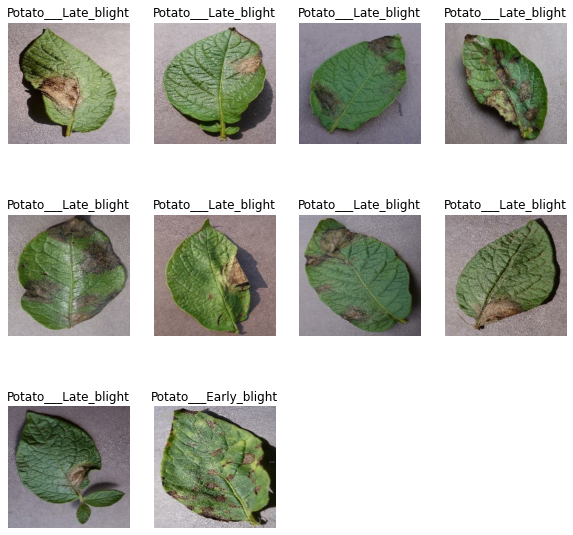

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(10):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
len(dataset)

68

In [10]:
##80% data ==> training
##20% data ==> 10% validation,10% test

In [11]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [12]:
train_ds = dataset.take(54) ##arr[:54] first 54 
len(train_ds)

54

In [13]:
test_ds = dataset.skip(54) ##arr[54:] after 54
len(test_ds)

14

In [14]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [15]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [16]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    ds.skip(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [18]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

54

In [20]:
len(val_ds)

6

In [21]:
len(test_ds)

8

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [23]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [24]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [25]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation="relu",input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation="softmax"),
])

model.build(input_shape=input_shape)

C:\Users\Dell\Anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 754ms/step - accuracy: 0.4362 - loss: 0.9474 - val_accuracy: 0.4271 - val_loss: 0.9122
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 708ms/step - accuracy: 0.5133 - loss: 0.9076 - val_accuracy: 0.5885 - val_loss: 0.8395
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 725ms/step - accuracy: 0.6476 - loss: 0.7822 - val_accuracy: 0.6667 - val_loss: 0.7171
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 705ms/step - accuracy: 0.7600 - loss: 0.5732 - val_accuracy: 0.8229 - val_loss: 0.4333
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 719ms/step - accuracy: 0.8065 - loss: 0.4969 - val_accuracy: 0.8438 - val_loss: 0.3817
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 710ms/step - accuracy: 0.8385 - loss: 0.3866 - val_accuracy: 0.8594 - val_loss: 0.3735
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 717ms/step - accuracy: 0.8344 - loss: 0.4340 - val_accuracy: 0.9115 - val_loss: 0.2187
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 708ms/step - accuracy: 0.8759 - loss: 0.2987 - val_accu

In [29]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 177ms/step - accuracy: 0.9844 - loss: 0.0370


In [30]:
scores

[0.033573687076568604, 0.984375]

In [31]:
history

In [32]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [33]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [34]:
history.history['accuracy']

[0.4652777910232544,
 0.5243055820465088,
 0.6793981194496155,
 0.7714120149612427,
 0.8084490895271301,
 0.8506944179534912,
 0.8559027910232544,
 0.8825231194496155,
 0.8998842835426331,
 0.9241898059844971,
 0.9155092835426331,
 0.9305555820465088,
 0.9456018805503845,
 0.9473379850387573,
 0.9502314925193787,
 0.9629629850387573,
 0.9681712985038757,
 0.9589120149612427,
 0.9722222089767456,
 0.9623842835426331,
 0.9704861044883728,
 0.9693287014961243,
 0.9675925970077515,
 0.9768518805503845,
 0.9837962985038757,
 0.984375,
 0.984375,
 0.9861111044883728,
 0.9646990895271301,
 0.9826388955116272,
 0.9855324029922485,
 0.9809027910232544,
 0.9814814925193787,
 0.9913194179534912,
 0.9884259104728699,
 0.9890046119689941,
 0.9814814925193787,
 0.9901620149612427,
 0.9878472089767456,
 0.9849537014961243,
 0.9924768805503845,
 0.96875,
 0.9826388955116272,
 0.9861111044883728,
 0.9890046119689941,
 0.9918981194496155,
 0.9930555820465088,
 0.9878472089767456,
 0.9837962985038757,
 0

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

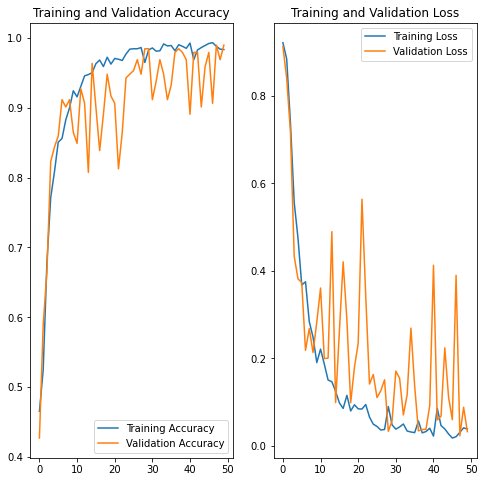

In [36]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

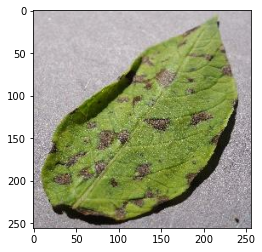

In [37]:
for images_batch, labels_batch in test_ds.take(1):
    plt.imshow(images_batch[0].numpy().astype('uint8'))

first image to predict
first image's actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
predicted Label: Potato___Early_blight


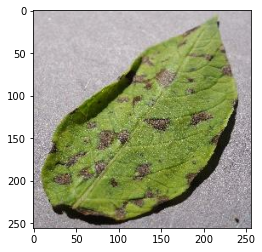

In [38]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted Label:",class_names[np.argmax(batch_prediction[0])])

In [39]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


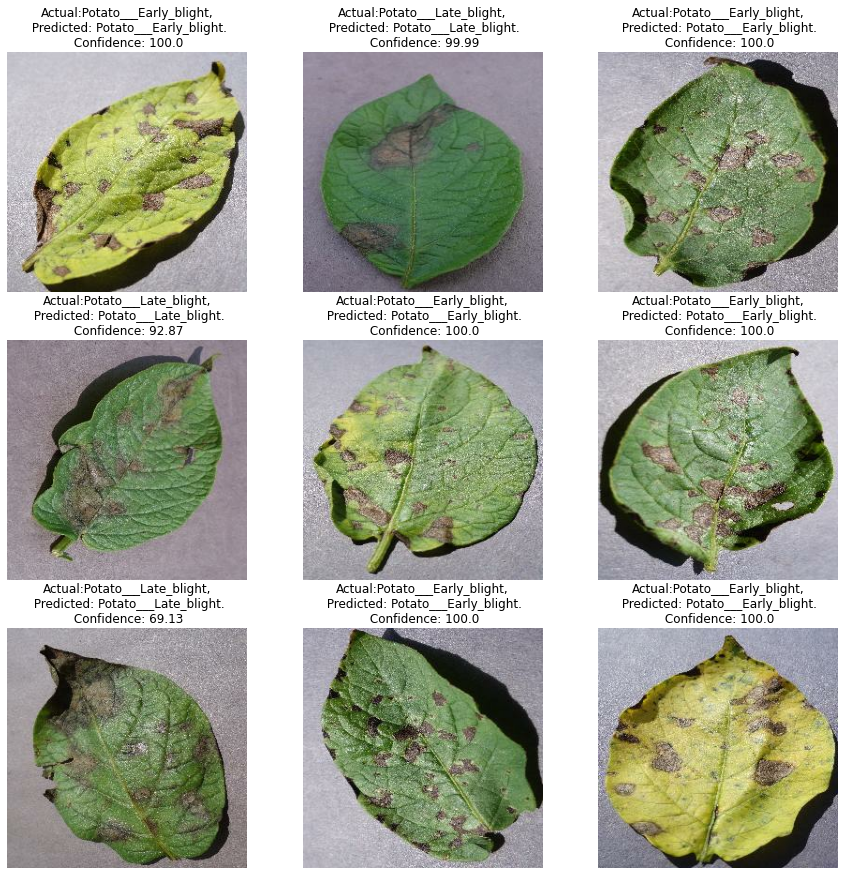

In [40]:
plt.figure(figsize=(15,15))
for images , labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}")
        plt.axis("off")

In [44]:
import os
model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1
save_path = f"../models/{model_version}.keras"
model.save(save_path)

ValueError: invalid literal for int() with base 10: '1.keras'

In [47]:
model_version = 4
save_path = f"../saved_models/{model_version}.keras"
model.save(save_path)